# Effectiveness prediction

In [3]:
import pandas as pd
import json
import random
import numpy as np

In [25]:
creative_data = pd.read_csv('./data/creative_data.csv')

In [6]:
creative_data.head()

,creative_id,no_of_days,impressions,clicks,campaign_counts,no_of_days_min,impressions_min,clicks_min,no_of_days_max,impressions_max,...,week_day,no_of_week_end,Display_days,Mobile_days,Search_days,Social_days,Video_days,country,ctir,effectiveness_category
0,1000,45,9471,152,5,7,837,8,11,2634,...,38,7,0,18,0,17,10,Singapore,1.604899,above_med
1,1005,5643,52011,638,66,53,524,2,118,2919,...,4869,774,1236,936,1913,826,732,US,1.226664,below_med
2,1010,5643,38026,519,66,53,514,2,118,787,...,4869,774,814,1354,1182,1193,1100,US,1.364856,above_med
3,1015,5643,48051,629,66,53,546,2,118,1653,...,4869,774,682,816,1417,1547,1181,US,1.309026,below_med
4,1020,5643,38519,512,66,53,514,3,118,878,...,4869,774,1198,1260,1109,985,1091,US,1.329214,above_med


## Classical image features

In [8]:
creative_features = pd.read_csv('./data/features/classical_creative_features.csv')

In [9]:
creative_features.head()

,creative_id,aspect_ratio,color,read_mean,green_mean,blue_mean,red_std,green_std,blue_std,brightness,...,blue_dom_color7,weight_dom_color7,red_dom_color8,green_dom_color8,blue_dom_color8,weight_dom_color8,red_dom_color9,green_dom_color9,blue_dom_color9,weight_dom_color9
0,1000,0.667188,1,0.199123,0.271816,0.371865,48.531470,36.073478,46.842777,0.261469,...,0.143347,0.031971,0.030897,0.375683,0.673309,0.043699,0.452279,0.529923,0.590956,0.044855
1,10000,1.319736,1,0.779949,0.779218,0.777672,56.022431,56.278342,56.366826,0.779306,...,0.555901,0.032253,0.606414,0.605481,0.600985,0.038587,0.382069,0.380722,0.376519,0.042227
2,10005,0.772727,0,0.145030,0.145030,0.145030,85.944494,85.944494,85.944494,0.145030,...,0.721242,0.002160,0.322807,0.322807,0.322807,0.002211,0.659941,0.659941,0.659941,0.002298
3,10010,1.777778,1,0.943396,0.369360,0.401235,44.115418,95.586132,85.899619,0.544297,...,0.534784,0.001066,0.566190,0.378674,0.322565,0.001541,0.505679,0.089081,0.061342,0.001569
4,10015,0.706250,1,0.628284,0.486499,0.436248,31.831054,36.820207,34.461763,0.523478,...,0.271857,0.014137,0.280988,0.152431,0.116449,0.015404,0.979414,0.748960,0.623834,0.016077


In [26]:
creative_data = pd.merge(creative_data, creative_features, on='creative_id')

In [27]:
creative_data.columns

Index(['creative_id', 'no_of_days', 'impressions', 'clicks', 'campaign_counts',
       'no_of_days_min', 'impressions_min', 'clicks_min', 'no_of_days_max',
       'impressions_max', 'clicks_max', 'week_day', 'no_of_week_end',
       'Display_days', 'Mobile_days', 'Search_days', 'Social_days',
       'Video_days', 'country', 'ctir', 'effectiveness_category',
       'aspect_ratio', 'color', 'read_mean', 'green_mean', 'blue_mean',
       'red_std', 'green_std', 'blue_std', 'brightness', 'contrast', 'entropy',
       'warm_fraction', 'cool_fraction', 'saturation_mean', 'red_dom_color0',
       'green_dom_color0', 'blue_dom_color0', 'weight_dom_color0',
       'red_dom_color1', 'green_dom_color1', 'blue_dom_color1',
       'weight_dom_color1', 'red_dom_color2', 'green_dom_color2',
       'blue_dom_color2', 'weight_dom_color2', 'red_dom_color3',
       'green_dom_color3', 'blue_dom_color3', 'weight_dom_color3',
       'red_dom_color4', 'green_dom_color4', 'blue_dom_color4',
       'weight_do

In [39]:
#split train/test

random.seed(42)
list_creative_ids = list(creative_data.index)
random.shuffle(list_creative_ids)

train_test_split_index = int(len(list_creative_ids) * 0.8)
creative_ids_train = list_creative_ids[:train_test_split_index]
creative_ids_test = list_creative_ids[train_test_split_index:]

train_data = creative_data.loc[creative_ids_train]
test_data = creative_data.loc[creative_ids_test]


Rather than regression of the metric we chose for effectiveness (CTIR), we are probably more interested in classification, or being able to predict if a creative will be effective or not. We defined already a category for this based on the CTIR. The thresholds were a bit arbritary, based on percentiles per country, but will be good enough for this exercise.

In [29]:
train_data.effectiveness_category.value_counts() / len(train_data)

effectiveness_category
below_med      0.496791
above_med      0.297818
good           0.154899
exceptional    0.050492
Name: count, dtype: float64

In [30]:
test_data.effectiveness_category.value_counts() / len(test_data)

effectiveness_category
below_med      0.509402
above_med      0.307692
good           0.129915
exceptional    0.052991
Name: count, dtype: float64

Thanks to the random split, the statistics of the category are practically equal between train and test datasets.
Let us reduce further the categories first and group together below and above med as 0 and good and exceptional as 1 for a binary class, which will be the target, "effective"

In [276]:
# train_data['effective'] = train_data.effectiveness_category.isin(['good', 'exceptional']).astype(int)
# test_data['effective'] = test_data.effectiveness_category.isin(['good', 'exceptional']).astype(int)
creative_data['effective'] = creative_data.effectiveness_category.isin(['good', 'exceptional']).astype(int)
creative_data['very_effective'] = creative_data.effectiveness_category.isin(['exceptional']).astype(int)
train_data = creative_data.loc[creative_ids_train].reset_index(drop=True)
test_data = creative_data.loc[creative_ids_test].reset_index(drop=True)

In [411]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [338]:
class CreativeEffectivenessModel:
    """
    Wrapper class for any kind of model. This can be repalced by a pipeline using kubeflow framework 
    """
    def __init__(self, model_class, features, target):
        if model_class == 'lgbm':
            params = {
                'objective': 'binary',  # Binary classification
                'metric': 'binary_logloss',#'auc',#
                'learning_rate': 0.05,
                'num_leaves': 31,
                'max_depth': 8,
                'n_estimators': 500,
                'verbose': -1,
                'is_unbalance': True,
                'random_state': 42
            }
            self.model = lgb.LGBMClassifier(**params)
        elif model_class == 'rf':
            params = {
                "n_estimators": 500,
                "criterion": 'logloss', #entroy, gini
                "max_depth": 8,
                "max_leaf_nodes": 31,
                "random_state": 42
            }
            self.model = RandomForestClassifier(**params)
        elif model_class == 'nb':
            self.model = GaussianNB()
        else:
            self.model = None
        self.model_class = model_class
        self.features = features
        self.target = target
        
    def train(self, train_data):
        train_data = train_data.copy()
        self.preprocess_fit(train_data)
        self.preprocess(train_data)
        X_train = train_data[self.features]
        y_train = train_data[self.target]
        # Train the model
        if self.model_class in ['lgbm', 'nb']:
            #train_lgb = lgb.Dataset(X_train, label=y_train)
            self.model.fit(X_train.values, y_train.values)
            
            
    def eval(self, test_data, threshold=0.5, verbose=True):
        test_data = test_data.copy()
        y_pred, y_pred_proba = self.predict(test_data, threshold=threshold)
        y_test = test_data[self.target]
        
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)  # Use probabilities for AUC
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        metrics = {
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
        if verbose:
            print(f"Accuracy: {accuracy:.2f}")
            print(f"ROC AUC: {roc_auc:.2f}")
            print(f"Precision: {precision:.2f}")
            print(f"Recall: {recall:.3f}")
            print(f"F1 Score: {f1:.3f}")
        return metrics
        
    def train_eval(self, train_data, test_data):
        self.train(train_data)
        return self.eval(test_data)
        
    def predict(self, data, threshold=0.5):
        self.preprocess(data)
        X = data[self.features]
        if self.model_class in ['lgbm', 'nb']:
            y_pred_proba = self.model.predict_proba(X.values)
            y_pred_proba = y_pred_proba[:, 1]

        y_pred = (y_pred_proba >= threshold).astype(int)
        return y_pred, y_pred_proba

    def preprocess_fit(self, train_data):
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(train_data['country'])
        
    def preprocess(self, data):
        data['encoded_country'] = self.label_encoder.transform(data['country'])
        
        
    
   

In [363]:
features = [#'no_of_days',
       # 'no_of_week_end',
       # 'Display_days', 'Mobile_days', 'Search_days', 'Social_days',
       # 'Video_days',
       'encoded_country',
       'aspect_ratio', 'color', 'read_mean', 'green_mean', 'blue_mean',
       'red_std', 'green_std', 'blue_std', 'brightness', 'contrast', 'entropy',
       'warm_fraction', 'cool_fraction', 'saturation_mean',
       'red_dom_color0',
       'green_dom_color0', 'blue_dom_color0', 'weight_dom_color0',
       'red_dom_color1', 'green_dom_color1', 'blue_dom_color1',
       'weight_dom_color1', 'red_dom_color2', 'green_dom_color2',
       'blue_dom_color2', 'weight_dom_color2', 'red_dom_color3',
       'green_dom_color3', 'blue_dom_color3', 'weight_dom_color3',
       # 'red_dom_color4', 'green_dom_color4', 'blue_dom_color4',
       # 'weight_dom_color4', 'red_dom_color5', 'green_dom_color5',
       # 'blue_dom_color5', 'weight_dom_color5', 'red_dom_color6',
       # 'green_dom_color6', 'blue_dom_color6', 'weight_dom_color6',
       # 'red_dom_color7', 'green_dom_color7', 'blue_dom_color7',
       # 'weight_dom_color7', 'red_dom_color8', 'green_dom_color8',
       # 'blue_dom_color8', 'weight_dom_color8', 'red_dom_color9',
       # 'green_dom_color9', 'blue_dom_color9', 'weight_dom_color9'
        ]
target = 'very_effective'
cem = CreativeEffectivenessModel('lgbm', features, target)
cem_error = cem.train_eval(train_data, test_data)

Accuracy: 0.94
ROC AUC: 0.46
Precision: 0.00
Recall: 0.000
F1 Score: 0.000


In [354]:
cem = CreativeEffectivenessModel('nb', features, target)
cem_error = cem.train_eval(train_data, test_data)

Accuracy: 0.17
ROC AUC: 0.46
Precision: 0.05
Recall: 0.871
F1 Score: 0.101


<Axes: >

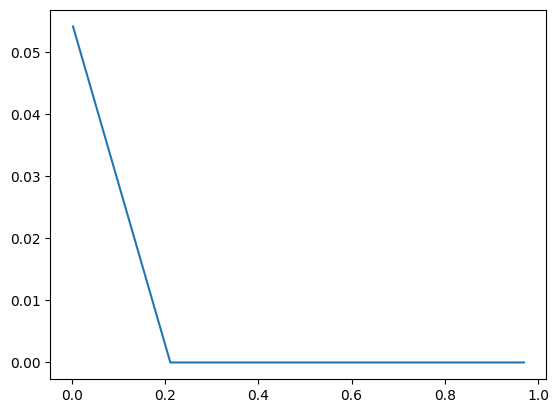

In [367]:
from sklearn.calibration import calibration_curve
y_pred, y_pred_proba = cem.predict(test_data)
prob_true, prob_pred = calibration_curve(test_data[target], y_pred_proba, n_bins=8)
pd.Series(index = prob_pred, data=prob_true).plot()

In [253]:
y_random = np.random.randint(0, 2, size=len(y_test))
accuracy = accuracy_score(y_test, y_random)
roc_auc = roc_auc_score(y_test, y_random) 
precision = precision_score(y_test, y_random)
recall = recall_score(y_test, y_random)
f1 = f1_score(y_test, y_random)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.5197
ROC AUC: 0.5102
Precision: 0.1893
Recall: 0.4953
F1 Score: 0.2739


In [252]:
prob_1 = y_train.mean()  # Probability of class 1
y_random = np.random.choice([0, 1], size=len(y_test), p=[1 - prob_1, prob_1])
accuracy = accuracy_score(y_test, y_random)
roc_auc = roc_auc_score(y_test, y_random) 
precision = precision_score(y_test, y_random)
recall = recall_score(y_test, y_random)
f1 = f1_score(y_test, y_random)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.6923
ROC AUC: 0.5143
Precision: 0.2033
Recall: 0.2336
F1 Score: 0.2174


In [254]:
y_0 = np.zeros(len(y_test))
accuracy = accuracy_score(y_test, y_0)
roc_auc = roc_auc_score(y_test, y_0)
precision = precision_score(y_test, y_0)
recall = recall_score(y_test, y_0)
f1 = f1_score(y_test, y_0)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8171
ROC AUC: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


C:\Users\david\projects\smartassets_challenge\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

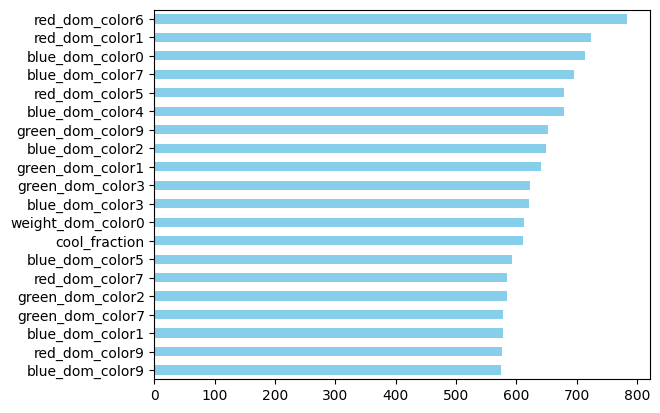

In [236]:
importance_df = pd.Series(index=features, data=cem.model.feature_importances_, name='feature importance')

top_20_features = importance_df.sort_values(ascending=False).head(20).sort_values()

# Plot the top 10 features
top_20_features.plot.barh(color='skyblue')


## Using modern feat

### Vision foundation model

In [66]:
with open('data/features/output_features_gvlab_vit6b.json', 'r') as jfile:
    dict_features = json.load(jfile)

In [165]:
vit_features = pd.DataFrame(pd.Series(dict_features).rename('vit_array'))
vit_features.index.name = 'creative_id'
vit_features.reset_index(inplace=True)
vit_features_columns = [f'vit_{i}' for i in range(len(vit_features['vit_array'][0]))]
df_vit = pd.DataFrame(vit_features['vit_array'].tolist(), columns=vit_features_columns)

vit_features = pd.concat([vit_features, df_vit], axis=1)

vit_features.drop(columns=['vit_array'], inplace=True)
vit_features.creative_id = vit_features.creative_id.astype(int)
vit_features.head()

,creative_id,vit_0,vit_1,vit_2,vit_3,vit_4,vit_5,vit_6,vit_7,vit_8,...,vit_3190,vit_3191,vit_3192,vit_3193,vit_3194,vit_3195,vit_3196,vit_3197,vit_3198,vit_3199
0,10120,-0.578125,0.138672,0.042969,1.546875,2.234375,-0.246094,0.253906,-0.324219,-3.234375,...,-3.125000,2.359375,-1.171875,1.046875,0.800781,2.562500,-0.166992,-0.244141,0.878906,-0.134766
1,10085,-0.769531,-1.945312,1.109375,-0.285156,0.441406,-0.498047,-1.304688,0.718750,-1.648438,...,-4.343750,1.031250,-0.875000,1.523438,0.406250,-0.131836,0.137695,-0.742188,0.120117,-0.072266
2,10060,-0.941406,-2.359375,1.546875,1.281250,-1.632812,1.804688,-0.765625,1.265625,-3.812500,...,-1.070312,1.734375,0.281250,0.492188,1.171875,-0.100586,2.703125,0.012695,0.550781,-2.031250
3,10075,-0.746094,-1.046875,1.234375,-1.117188,1.125000,-0.289062,-1.687500,2.375000,-1.570312,...,-3.671875,1.789062,-0.312500,-0.652344,-0.757812,1.007812,0.021362,0.316406,0.196289,-2.515625
4,10055,-0.800781,-1.843750,0.679688,-0.621094,-1.562500,1.515625,-1.546875,0.585938,-1.343750,...,-4.593750,1.390625,0.082031,0.277344,-0.921875,1.460938,1.601562,-0.114746,0.917969,-0.875000


In [166]:
creative_data_vit = pd.merge(creative_data, vit_features, on='creative_id')
creative_data_vit.head()

,creative_id,no_of_days,impressions,clicks,campaign_counts,no_of_days_min,impressions_min,clicks_min,no_of_days_max,impressions_max,...,vit_3190,vit_3191,vit_3192,vit_3193,vit_3194,vit_3195,vit_3196,vit_3197,vit_3198,vit_3199
0,1000,45,9471,152,5,7,837,8,11,2634,...,-3.421875,1.593750,-0.765625,0.941406,-0.835938,-0.257812,-0.027588,-0.277344,0.738281,-0.115234
1,1005,5643,52011,638,66,53,524,2,118,2919,...,-5.312500,2.078125,0.320312,0.710938,1.695312,1.250000,-0.240234,-1.390625,1.648438,-0.960938
2,1010,5643,38026,519,66,53,514,2,118,787,...,-0.765625,2.265625,0.068359,0.820312,2.031250,0.960938,0.476562,-0.980469,1.039062,-0.308594
3,1015,5643,48051,629,66,53,546,2,118,1653,...,-4.375000,1.484375,1.796875,1.296875,-0.722656,0.204102,-0.890625,-2.218750,1.625000,-0.503906
4,1020,5643,38519,512,66,53,514,3,118,878,...,-3.671875,0.933594,0.058594,1.117188,-0.738281,0.455078,0.242188,-0.808594,0.808594,-0.968750


In [368]:
train_data = creative_data_vit.loc[creative_ids_train].reset_index(drop=True)
test_data = creative_data_vit.loc[creative_ids_test].reset_index(drop=True)

In [369]:
features = [#'no_of_days', 'no_of_week_end',
       #'Display_days', 'Mobile_days', 'Search_days', 'Social_days',
       #'Video_days',
       'encoded_country', 'aspect_ratio',
       #  'color', 'read_mean', 'green_mean', 'blue_mean',
       # 'red_std', 'green_std', 'blue_std', 'brightness', 'contrast', 'entropy',
       # 'warm_fraction', 'cool_fraction', 'saturation_mean', 'red_dom_color0',
       # 'green_dom_color0', 'blue_dom_color0', 'weight_dom_color0',
       # 'red_dom_color1', 'green_dom_color1', 'blue_dom_color1',
       # 'weight_dom_color1', 'red_dom_color2', 'green_dom_color2',
       # 'blue_dom_color2', 'weight_dom_color2', 'red_dom_color3',
       # 'green_dom_color3', 'blue_dom_color3', 'weight_dom_color3',
       # 'red_dom_color4', 'green_dom_color4', 'blue_dom_color4',
       # 'weight_dom_color4', 'red_dom_color5', 'green_dom_color5',
       # 'blue_dom_color5', 'weight_dom_color5', 'red_dom_color6',
       # 'green_dom_color6', 'blue_dom_color6', 'weight_dom_color6',
       # 'red_dom_color7', 'green_dom_color7', 'blue_dom_color7',
       # 'weight_dom_color7', 'red_dom_color8', 'green_dom_color8',
       # 'blue_dom_color8', 'weight_dom_color8', 'red_dom_color9',
       # 'green_dom_color9', 'blue_dom_color9', 'weight_dom_color9'
    ]
features += vit_features_columns
target = 'effective'


In [370]:
cem = CreativeEffectivenessModel('lgbm', features, target)
cem_error = cem.train_eval(train_data, test_data)

Accuracy: 0.78
ROC AUC: 0.47
Precision: 0.19
Recall: 0.065
F1 Score: 0.098


{'accuracy': 0.7794871794871795,
 'roc_auc': np.float64(0.469010284284206),
 'precision': np.float64(0.19444444444444445),
 'recall': np.float64(0.06542056074766354),
 'f1': np.float64(0.0979020979020979)}

In [240]:
cem.eval(test_data, threshold=0.6)

Accuracy: 0.79
ROC AUC: 0.50
Precision: 0.21
Recall: 0.056
F1 Score: 0.089


<Axes: >

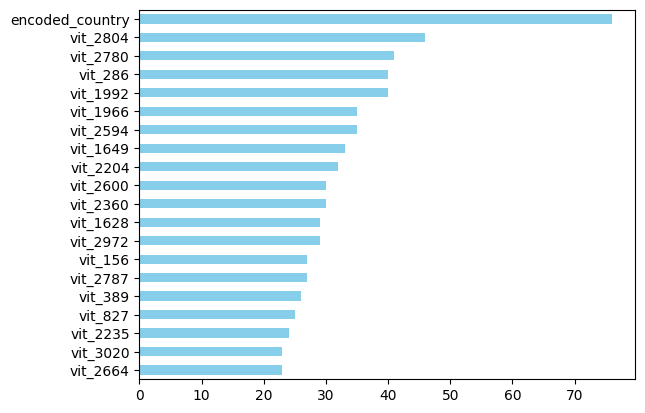

In [371]:
importance_df = pd.Series(index=features, data=cem.model.feature_importances_, name='feature importance')

top_20_features = importance_df.sort_values(ascending=False).head(20).sort_values()

# Plot the top 10 features
top_20_features.plot.barh(color='skyblue')

<Axes: >

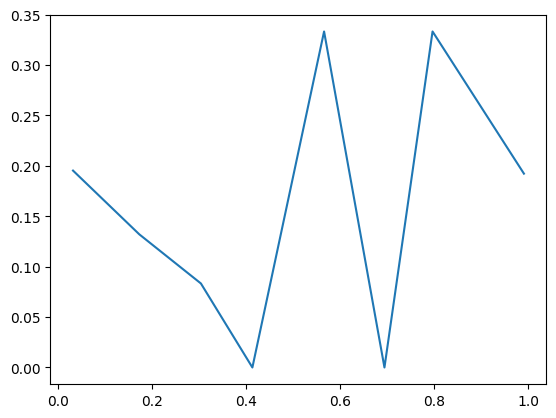

In [372]:
y_pred, y_pred_proba = cem.predict(test_data)
prob_true, prob_pred = calibration_curve(test_data[target], y_pred_proba, n_bins=8)
pd.Series(index = prob_pred, data=prob_true).plot()

In [102]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA, KernelPCA
from scipy.special import softmax

In [374]:
dimred_method = 'kmeans'#'kpca' #'kmeans'
normalizer = Normalizer(norm='l2')
if dim_red_method == 'kpca':
    cluster_vit = KernelPCA(n_components=100, kernel='sigmoid')#
elif dim_red_method == 'kmeans':
    cluster_vit = KMeans(n_clusters=100)
vit_train_data_normalized = normalizer.fit_transform(train_data[vit_features_columns]) #train_data[vit_features_columns]#
vit_test_data_normalized = normalizer.transform(test_data[vit_features_columns]) #test_data[vit_features_columns]#

cluster_vit.fit(vit_train_data_normalized)

KernelPCA(kernel='sigmoid', n_components=100)

In [375]:
trans_vit_columns = [f'trans_{i}' for i in range(trans_feat_train.shape[1])]
if dim_red_method == 'kpca':
    trans_feat_train = cluster_vit.transform(vit_train_data_normalized)#train_data[vit_features_columns])
    trans_feat_test = cluster_vit.transform(vit_test_data_normalized)#test_data[vit_features_columns])
elif dim_red_method == 'kmeans':
    dist_train = cluster_vit.transform(vit_train_data_normalized)
    dist_test = cluster_vit.transform(vit_test_data_normalized)
    trans_feat_train = softmax(-dist_train, axis=1)
    trans_feat_test = softmax(-dist_test, axis=1)

In [376]:

train_data_trans = pd.concat((train_data, 
                        pd.DataFrame(trans_feat_train, columns=trans_vit_columns)),
                       axis=1)
test_data_trans = pd.concat((test_data, 
                        pd.DataFrame(trans_feat_test, columns=trans_vit_columns)),
                       axis=1)

In [377]:
features = [#'no_of_days', 'no_of_week_end',
       #'Display_days', 'Mobile_days', 'Search_days', 'Social_days',
       #'Video_days',
       'encoded_country', 'aspect_ratio',
       #  'color', 'read_mean', 'green_mean', 'blue_mean',
       # 'red_std', 'green_std', 'blue_std', 'brightness', 'contrast', 'entropy',
       # 'warm_fraction', 'cool_fraction', 'saturation_mean', 'red_dom_color0',
       # 'green_dom_color0', 'blue_dom_color0', 'weight_dom_color0',
       # 'red_dom_color1', 'green_dom_color1', 'blue_dom_color1',
       # 'weight_dom_color1', 'red_dom_color2', 'green_dom_color2',
       # 'blue_dom_color2', 'weight_dom_color2', 'red_dom_color3',
       # 'green_dom_color3', 'blue_dom_color3', 'weight_dom_color3',
       # 'red_dom_color4', 'green_dom_color4', 'blue_dom_color4',
       # 'weight_dom_color4', 'red_dom_color5', 'green_dom_color5',
       # 'blue_dom_color5', 'weight_dom_color5', 'red_dom_color6',
       # 'green_dom_color6', 'blue_dom_color6', 'weight_dom_color6',
       # 'red_dom_color7', 'green_dom_color7', 'blue_dom_color7',
       # 'weight_dom_color7', 'red_dom_color8', 'green_dom_color8',
       # 'blue_dom_color8', 'weight_dom_color8', 'red_dom_color9',
       # 'green_dom_color9', 'blue_dom_color9', 'weight_dom_color9'
    ]
features += trans_vit_columns
target = 'effective'

In [379]:
cem = CreativeEffectivenessModel('lgbm', features, target)
cem_error = cem.train_eval(train_data_trans, test_data_trans)

Accuracy: 0.77
ROC AUC: 0.49
Precision: 0.14
Recall: 0.047
F1 Score: 0.070


In [380]:
cem = CreativeEffectivenessModel('nb', features, target)
cem_error = cem.train_eval(train_data_trans, test_data_trans)

Accuracy: 0.80
ROC AUC: 0.46
Precision: 0.14
Recall: 0.019
F1 Score: 0.033


<Axes: >

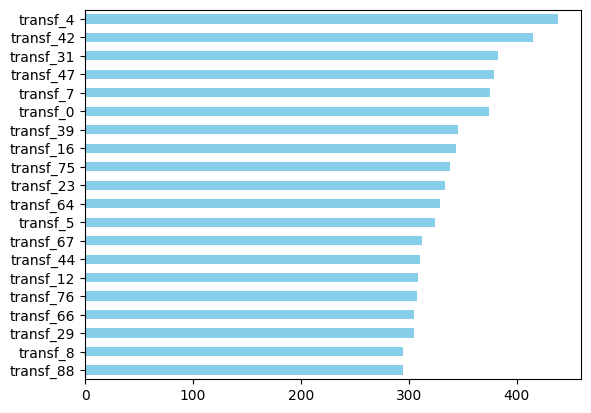

In [251]:
importance_df = pd.Series(index=features, data=cem.model.feature_importances_, name='feature importance')

top_20_features = importance_df.sort_values(ascending=False).head(20).sort_values()

# Plot the top 10 features
top_20_features.plot.barh(color='skyblue')

### Image classification model embeddings

In [382]:
with open('data/features/output_features_dinov2.json', 'r') as jfile:
    dict_features = json.load(jfile)

In [383]:
vit_features2 = pd.DataFrame(pd.Series(dict_features).rename('vit_array'))
vit_features2.index.name = 'creative_id'
vit_features2.reset_index(inplace=True)
vit_features2_columns = [f'vit2_{i}' for i in range(len(vit_features2['vit_array'][0]))]
df_vit = pd.DataFrame(vit_features2['vit_array'].tolist(), columns=vit_features2_columns)

vit_features2 = pd.concat([vit_features2, df_vit], axis=1)

vit_features2.drop(columns=['vit_array'], inplace=True)
vit_features2.creative_id = vit_features2.creative_id.astype(int)
vit_features2.head()

,creative_id,vit2_0,vit2_1,vit2_2,vit2_3,vit2_4,vit2_5,vit2_6,vit2_7,vit2_8,...,vit2_1014,vit2_1015,vit2_1016,vit2_1017,vit2_1018,vit2_1019,vit2_1020,vit2_1021,vit2_1022,vit2_1023
0,6530,0.624470,-1.101754,0.000121,-1.064858,0.065610,2.169576,2.382757,2.472283,-1.933884,...,0.428459,-0.170853,-0.997335,0.738035,-2.520880,2.154590,2.837575,-0.047424,1.670954,-0.963061
1,1935,-0.790247,0.440206,1.607563,2.184415,-1.364528,1.629077,-0.828082,-2.185295,0.977420,...,-0.311954,-1.030939,1.104574,-1.026952,-1.395897,-0.642299,1.642810,-1.683116,2.405503,-0.681553
2,2965,-0.100646,-0.148089,-1.537327,-1.244880,-2.543138,-0.030747,-0.679018,0.170891,-1.292697,...,-0.674922,2.764979,-1.553253,0.470021,-0.580987,-0.610401,2.185077,0.323379,-0.856441,0.424475
3,2795,-0.460877,0.117311,-0.970718,-1.411302,-3.543148,-0.504490,1.316466,0.933544,-0.087106,...,0.761374,1.250634,0.423930,-1.138609,0.715299,0.584324,-1.363064,-0.863721,-0.720136,-1.512654
4,15195,-0.022956,-1.811956,-1.397774,-0.736002,5.134972,0.949165,-0.413611,0.026690,-0.037014,...,-1.292646,1.665884,2.367265,1.406205,-4.441287,1.081416,1.517972,1.126448,1.478040,-1.441418


In [384]:
creative_data_vit2 = pd.merge(creative_data_vit, vit_features2, on='creative_id')
creative_data_vit2.head()

,creative_id,no_of_days,impressions,clicks,campaign_counts,no_of_days_min,impressions_min,clicks_min,no_of_days_max,impressions_max,...,vit2_1014,vit2_1015,vit2_1016,vit2_1017,vit2_1018,vit2_1019,vit2_1020,vit2_1021,vit2_1022,vit2_1023
0,1000,45,9471,152,5,7,837,8,11,2634,...,0.508590,-0.692782,1.324966,-0.158711,-1.033647,0.968537,1.340514,2.440877,0.199821,-1.397338
1,1005,5643,52011,638,66,53,524,2,118,2919,...,0.151265,1.341167,0.799647,-2.138361,-0.803534,-1.852702,-0.014473,1.278071,-1.923319,-1.514643
2,1010,5643,38026,519,66,53,514,2,118,787,...,-1.807695,2.010891,-0.138691,0.133348,0.191853,2.163582,4.568373,0.947788,-1.249356,1.713279
3,1015,5643,48051,629,66,53,546,2,118,1653,...,-0.200617,0.348464,1.678512,-1.595172,-0.258718,3.116216,0.143125,0.354630,-2.422630,-0.784396
4,1020,5643,38519,512,66,53,514,3,118,878,...,0.485034,1.595787,0.882823,-0.793838,-1.385468,1.543669,1.008731,2.025580,-0.690522,-0.011896


In [385]:
train_data = creative_data_vit2.loc[creative_ids_train].reset_index(drop=True)
test_data = creative_data_vit2.loc[creative_ids_test].reset_index(drop=True)

In [393]:
features = [
   #'no_of_days', 'no_of_week_end',
   #'Display_days', 'Mobile_days', 'Search_days', 'Social_days',
   #'Video_days',
   'encoded_country', 'aspect_ratio',
   #  'color', 'read_mean', 'green_mean', 'blue_mean',
   # 'red_std', 'green_std', 'blue_std', 'brightness', 'contrast', 'entropy',
   # 'warm_fraction', 'cool_fraction', 'saturation_mean', 'red_dom_color0',
   # 'green_dom_color0', 'blue_dom_color0', 'weight_dom_color0',
   # 'red_dom_color1', 'green_dom_color1', 'blue_dom_color1',
   # 'weight_dom_color1', 'red_dom_color2', 'green_dom_color2',
   # 'blue_dom_color2', 'weight_dom_color2', 'red_dom_color3',
   # 'green_dom_color3', 'blue_dom_color3', 'weight_dom_color3',
   # 'red_dom_color4', 'green_dom_color4', 'blue_dom_color4',
   # 'weight_dom_color4', 'red_dom_color5', 'green_dom_color5',
   # 'blue_dom_color5', 'weight_dom_color5', 'red_dom_color6',
   # 'green_dom_color6', 'blue_dom_color6', 'weight_dom_color6',
   # 'red_dom_color7', 'green_dom_color7', 'blue_dom_color7',
   # 'weight_dom_color7', 'red_dom_color8', 'green_dom_color8',
   # 'blue_dom_color8', 'weight_dom_color8', 'red_dom_color9',
   # 'green_dom_color9', 'blue_dom_color9', 'weight_dom_color9'
    ]
features += vit_features2_columns
target = 'effective'

In [394]:
cem = CreativeEffectivenessModel('lgbm', features, target)
cem_error = cem.train_eval(train_data, test_data)

Accuracy: 0.78
ROC AUC: 0.48
Precision: 0.17
Recall: 0.047
F1 Score: 0.074


<Axes: >

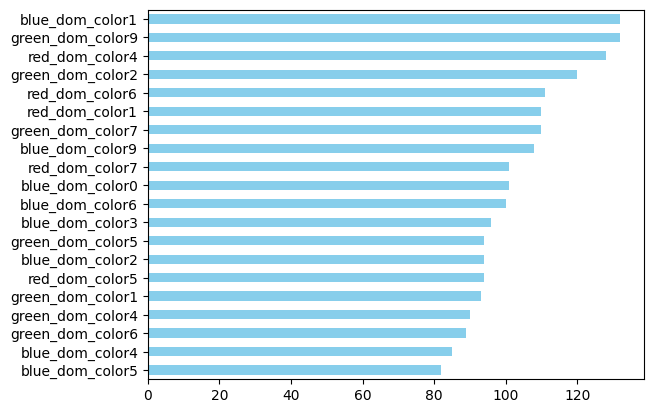

In [392]:
importance_df = pd.Series(index=features, data=cem.model.feature_importances_, name='feature importance')

top_features = importance_df.sort_values(ascending=False).head(20).sort_values()

# Plot the top features
top_features.plot.barh(color='skyblue')


<Axes: >

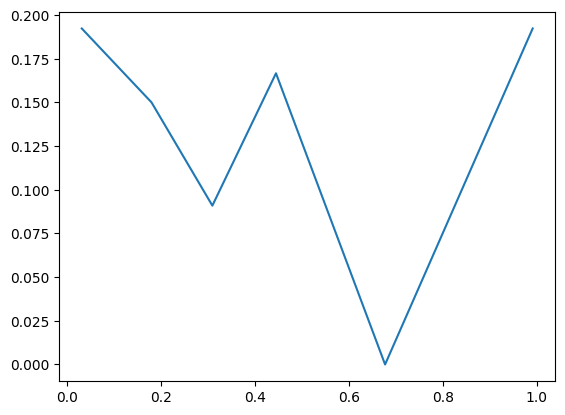

In [395]:
y_pred, y_pred_proba = cem.predict(test_data)
prob_true, prob_pred = calibration_curve(test_data[target], y_pred_proba, n_bins=8)
pd.Series(index = prob_pred, data=prob_true).plot()

In [438]:
## nn layer for as classifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class EffectivenessViT(nn.Module):
    def __init__(self, num_features):
        super(EffectivenessViT, self).__init__()
        # singe Linear layer 
        self.classifier = nn.Linear(num_features, 1)
        #self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        probs = self.sigmoid(self.classifier(x))  # Pass through the classifier
        return probs



In [440]:
class CreativeEffectivenessModel:
    """
    Wrapper class for any kind of model. This can be repalced by a pipeline using kubeflow framework 
    """
    def __init__(self, model_class, features, target):
        if model_class == 'lgbm':
            params = {
                'objective': 'binary',  # Binary classification
                'metric': 'binary_logloss',#'auc',#
                'learning_rate': 0.05,
                'num_leaves': 31,
                'max_depth': 8,
                'n_estimators': 500,
                'verbose': -1,
                'is_unbalance': True,
                'random_state': 42
            }
            self.model = lgb.LGBMClassifier(**params)
        elif model_class == 'rf':
            params = {
                "n_estimators": 500,
                "criterion": 'logloss', #entroy, gini
                "max_depth": 8,
                "max_leaf_nodes": 31,
                "random_state": 42
            }
            self.model = RandomForestClassifier(**params)
        elif model_class == 'nb':
            self.model = GaussianNB()
        elif model_class == 'nn1':
            self.model = EffectivenessViT(len(features))
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            self.model.to(device)
        elif model_class == 'nn2':
            self.model = EffectivenessViT2(len(features))
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            self.model.to(device)
        else:
            self.model = None
        self.model_class = model_class
        self.features = features
        self.target = target
        
    def train(self, train_data, verbose=True):
        X_train = self.preprocess_fit(train_data[features].copy())
        # = self.preprocess(train_data[features])
        #X_train = train_data[self.features]
        y_train = train_data[self.target].values
        # Train the model
        if self.model_class in ['lgbm', 'nb']:
            #train_lgb = lgb.Dataset(X_train, label=y_train)
            self.model.fit(X_train, y_train)
        elif self.model_class in ['nn1', 'nn2']:
            X_tensor = torch.tensor(X_train, dtype=torch.float32)
            y_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
            
            dataset = TensorDataset(X_tensor, y_tensor)
            dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
            criterion = nn.BCELoss()
            optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
            n_epochs = 40
            self.model.train()
            
            for epoch in range(n_epochs):
                running_loss = 0.0
                for batch_X, batch_y in dataloader:
                    
                    optimizer.zero_grad()
            
                    outputs = self.model(batch_X)
                    
                    loss = criterion(outputs, batch_y)
                    
                    loss.backward()
                    optimizer.step()
            
                    running_loss += loss.item()
                if verbose:
                    print(f'Epoch [{epoch+1}/{n_epochs}],' +
                            f'Loss: {running_loss/len(dataloader):.4f}')
        
            
    def eval(self, test_data, threshold=0.5, verbose=True):
        test_data = test_data.copy()
        y_pred, y_pred_proba = self.predict(test_data, threshold=threshold)
        y_test = test_data[self.target]
        
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)  # Use probabilities for AUC
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        metrics = {
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
        if verbose:
            print(f"Accuracy: {accuracy:.2f}")
            print(f"ROC AUC: {roc_auc:.2f}")
            print(f"Precision: {precision:.2f}")
            print(f"Recall: {recall:.3f}")
            print(f"F1 Score: {f1:.3f}")
        return metrics
        
    def train_eval(self, train_data, test_data):
        self.train(train_data)
        return self.eval(test_data)
        
    def predict(self, data, threshold=0.5):
        X = self.preprocess(data[self.features].copy())
        if self.model_class in ['lgbm', 'nb']:
            y_pred_proba = self.model.predict_proba(X)
            y_pred_proba = y_pred_proba[:, 1]
        elif self.model_class in ['nn1', 'nn2']:
            self.model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                X_tensor = torch.tensor(X, dtype=torch.float32)
                y_pred_proba = self.model(X_tensor).numpy()
        y_pred = (y_pred_proba >= threshold).astype(int)
        return y_pred, y_pred_proba

    def preprocess_fit(self, train_data):
        if ('country' in train_data.columns):
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(train_data['country'])
            train_data['country'] = self.label_encoder.transform(train_data['country'])
        if self.model_class in ['nn1', 'nn2']:
            self.scaler = StandardScaler()
            self.scaler.fit(train_data)
            return self.scaler.transform(train_data)
        else:
            return train_data.values
        
    def preprocess(self, data):
        if ('country' in data.columns):
            data['country'] = self.label_encoder.transform(data['country'])
        if self.model_class in ['nn1', 'nn2']:
            return self.scaler.transform(data)
        else:
            return data.values
        

In [446]:
features = [
   # 'no_of_days', 'no_of_week_end',
   # 'Display_days', 'Mobile_days', 'Search_days', 'Social_days',
   # 'Video_days',
     'country',
     'aspect_ratio',
   #  'color', 'read_mean', 'green_mean', 'blue_mean',
   # 'red_std', 'green_std', 'blue_std', 'brightness', 'contrast', 'entropy',
   # 'warm_fraction', 'cool_fraction', 'saturation_mean', 'red_dom_color0',
   # 'green_dom_color0', 'blue_dom_color0', 'weight_dom_color0',
   # 'red_dom_color1', 'green_dom_color1', 'blue_dom_color1',
   # 'weight_dom_color1', 'red_dom_color2', 'green_dom_color2',
   # 'blue_dom_color2', 'weight_dom_color2', 'red_dom_color3',
   # 'green_dom_color3', 'blue_dom_color3', 'weight_dom_color3',
   # 'red_dom_color4', 'green_dom_color4', 'blue_dom_color4',
   # 'weight_dom_color4', 'red_dom_color5', 'green_dom_color5',
   # 'blue_dom_color5', 'weight_dom_color5', 'red_dom_color6',
   # 'green_dom_color6', 'blue_dom_color6', 'weight_dom_color6',
   # 'red_dom_color7', 'green_dom_color7', 'blue_dom_color7',
   # 'weight_dom_color7', 'red_dom_color8', 'green_dom_color8',
   # 'blue_dom_color8', 'weight_dom_color8', 'red_dom_color9',
   # 'green_dom_color9', 'blue_dom_color9', 'weight_dom_color9'
    ]
#features += vit_features2_columns
features += vit_features_columns
target = 'effective'
cem = CreativeEffectivenessModel('nn1', features, target)
cem_error = cem.train_eval(train_data, test_data)

Epoch [1/40],Loss: 0.7669
Epoch [2/40],Loss: 0.6923
Epoch [3/40],Loss: 0.6398
Epoch [4/40],Loss: 0.6049
Epoch [5/40],Loss: 0.5937
Epoch [6/40],Loss: 0.5630
Epoch [7/40],Loss: 0.5163
Epoch [8/40],Loss: 0.4960
Epoch [9/40],Loss: 0.4695
Epoch [10/40],Loss: 0.4578
Epoch [11/40],Loss: 0.4387
Epoch [12/40],Loss: 0.4214
Epoch [13/40],Loss: 0.3936
Epoch [14/40],Loss: 0.3833
Epoch [15/40],Loss: 0.3758
Epoch [16/40],Loss: 0.3846
Epoch [17/40],Loss: 0.4090
Epoch [18/40],Loss: 0.3509
Epoch [19/40],Loss: 0.3466
Epoch [20/40],Loss: 0.3241
Epoch [21/40],Loss: 0.3202
Epoch [22/40],Loss: 0.3113
Epoch [23/40],Loss: 0.3067
Epoch [24/40],Loss: 0.3048
Epoch [25/40],Loss: 0.2882
Epoch [26/40],Loss: 0.2817
Epoch [27/40],Loss: 0.2746
Epoch [28/40],Loss: 0.2709
Epoch [29/40],Loss: 0.2649
Epoch [30/40],Loss: 0.2647
Epoch [31/40],Loss: 0.2543
Epoch [32/40],Loss: 0.2453
Epoch [33/40],Loss: 0.2354
Epoch [34/40],Loss: 0.2443
Epoch [35/40],Loss: 0.2679
Epoch [36/40],Loss: 0.2535
Epoch [37/40],Loss: 0.2550
Epoch [38/

<Axes: >

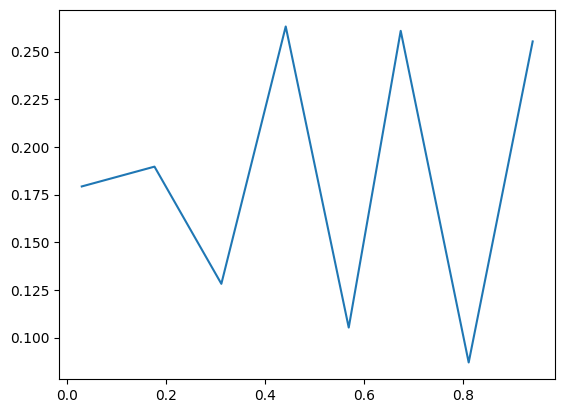

In [437]:
y_pred, y_pred_proba = cem.predict(test_data)
prob_true, prob_pred = calibration_curve(test_data[target], y_pred_proba, n_bins=8)
pd.Series(index = prob_pred, data=prob_true).plot()

In [443]:

class EffectivenessViT2(nn.Module):
    def __init__(self, num_features):
        super(EffectivenessViT2, self).__init__()
        self.l1 = nn.Linear(num_features, 128)
        self.l2 = nn.Linear(128, 32)
        self.classifier = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        probs = self.sigmoid(self.classifier(x))  # Pass through the classifier
        return probs



In [448]:
features = [
   # 'no_of_days', 'no_of_week_end',
   # 'Display_days', 'Mobile_days', 'Search_days', 'Social_days',
   # 'Video_days',
     'country',
     'aspect_ratio',
   #  'color', 'read_mean', 'green_mean', 'blue_mean',
   # 'red_std', 'green_std', 'blue_std', 'brightness', 'contrast', 'entropy',
   # 'warm_fraction', 'cool_fraction', 'saturation_mean', 'red_dom_color0',
   # 'green_dom_color0', 'blue_dom_color0', 'weight_dom_color0',
   # 'red_dom_color1', 'green_dom_color1', 'blue_dom_color1',
   # 'weight_dom_color1', 'red_dom_color2', 'green_dom_color2',
   # 'blue_dom_color2', 'weight_dom_color2', 'red_dom_color3',
   # 'green_dom_color3', 'blue_dom_color3', 'weight_dom_color3',
   # 'red_dom_color4', 'green_dom_color4', 'blue_dom_color4',
   # 'weight_dom_color4', 'red_dom_color5', 'green_dom_color5',
   # 'blue_dom_color5', 'weight_dom_color5', 'red_dom_color6',
   # 'green_dom_color6', 'blue_dom_color6', 'weight_dom_color6',
   # 'red_dom_color7', 'green_dom_color7', 'blue_dom_color7',
   # 'weight_dom_color7', 'red_dom_color8', 'green_dom_color8',
   # 'blue_dom_color8', 'weight_dom_color8', 'red_dom_color9',
   # 'green_dom_color9', 'blue_dom_color9', 'weight_dom_color9'
    ]
features += vit_features2_columns
features += vit_features_columns
target = 'effective'
cem = CreativeEffectivenessModel('nn2', features, target)
cem_error = cem.train_eval(train_data, test_data)

Epoch [1/40],Loss: 0.5359
Epoch [2/40],Loss: 0.4365
Epoch [3/40],Loss: 0.3575
Epoch [4/40],Loss: 0.2650
Epoch [5/40],Loss: 0.2013
Epoch [6/40],Loss: 0.1598
Epoch [7/40],Loss: 0.1413
Epoch [8/40],Loss: 0.1268
Epoch [9/40],Loss: 0.1064
Epoch [10/40],Loss: 0.1383
Epoch [11/40],Loss: 0.1183
Epoch [12/40],Loss: 0.1161
Epoch [13/40],Loss: 0.0898
Epoch [14/40],Loss: 0.0730
Epoch [15/40],Loss: 0.0705
Epoch [16/40],Loss: 0.0680
Epoch [17/40],Loss: 0.0629
Epoch [18/40],Loss: 0.0560
Epoch [19/40],Loss: 0.0570
Epoch [20/40],Loss: 0.0565
Epoch [21/40],Loss: 0.0540
Epoch [22/40],Loss: 0.0530
Epoch [23/40],Loss: 0.0534
Epoch [24/40],Loss: 0.0593
Epoch [25/40],Loss: 0.0587
Epoch [26/40],Loss: 0.0562
Epoch [27/40],Loss: 0.0524
Epoch [28/40],Loss: 0.0544
Epoch [29/40],Loss: 0.0531
Epoch [30/40],Loss: 0.0507
Epoch [31/40],Loss: 0.0524
Epoch [32/40],Loss: 0.0556
Epoch [33/40],Loss: 0.0521
Epoch [34/40],Loss: 0.0540
Epoch [35/40],Loss: 0.0581
Epoch [36/40],Loss: 0.1333
Epoch [37/40],Loss: 0.1343
Epoch [38/

### Image to text - embeddings

In [449]:
with open('data/features/output_embed_captions.json', 'r') as jfile:
    dict_features = json.load(jfile)

In [451]:
cap_features = pd.DataFrame(pd.Series(dict_features).rename('cap_array'))
cap_features.index.name = 'creative_id'
cap_features.reset_index(inplace=True)
cap_features_columns = [f'cap_{i}' for i in range(len(cap_features['cap_array'][0]))]
df_cap = pd.DataFrame(cap_features['cap_array'].tolist(), columns=cap_features_columns)

cap_features = pd.concat([cap_features, df_cap], axis=1)

cap_features.drop(columns=['cap_array'], inplace=True)
cap_features.creative_id = cap_features.creative_id.astype(int)
cap_features.head()

,creative_id,cap_0,cap_1,cap_2,cap_3,cap_4,cap_5,cap_6,cap_7,cap_8,...,cap_758,cap_759,cap_760,cap_761,cap_762,cap_763,cap_764,cap_765,cap_766,cap_767
0,6530,-0.022333,-0.038696,-0.101679,0.071254,0.028966,-0.029837,0.000091,0.024638,-0.064123,...,0.006072,-0.080577,0.029976,0.022809,0.044944,0.087174,-0.132366,0.098041,0.051489,0.049778
1,1935,0.112597,0.004799,-0.180030,0.016855,-0.110323,-0.078726,0.038380,0.091134,-0.056312,...,0.066037,0.028409,-0.064445,0.018046,0.039118,0.115481,-0.013722,0.015879,0.009497,0.081799
2,2965,0.076550,-0.053302,-0.162661,-0.003123,-0.077004,-0.082090,0.001749,0.065260,0.003042,...,0.106322,-0.051949,0.017465,0.067951,0.132236,0.060624,-0.015043,0.173507,0.111043,0.021062
3,2795,0.005605,0.052984,-0.043242,0.078549,-0.021410,-0.023727,0.026906,0.059497,0.080096,...,0.128398,-0.110454,-0.047293,0.144515,-0.021567,0.098259,-0.051132,0.111706,0.005780,0.000484
4,15195,0.093398,-0.032650,-0.150835,0.079075,-0.019503,-0.021055,-0.012013,0.151470,0.015061,...,0.072850,-0.035045,-0.009511,0.047048,0.035702,0.099220,0.032503,0.123980,0.046897,-0.051719


In [452]:
creative_data_cap = pd.merge(creative_data_vit2, cap_features, on='creative_id')
creative_data_cap.head()

,creative_id,no_of_days,impressions,clicks,campaign_counts,no_of_days_min,impressions_min,clicks_min,no_of_days_max,impressions_max,...,cap_758,cap_759,cap_760,cap_761,cap_762,cap_763,cap_764,cap_765,cap_766,cap_767
0,1000,45,9471,152,5,7,837,8,11,2634,...,-0.079931,-0.021899,0.104613,0.030679,0.086324,0.183646,-0.059469,0.004998,-0.079400,-0.024507
1,1005,5643,52011,638,66,53,524,2,118,2919,...,0.022289,-0.054080,0.014924,0.065613,0.059866,0.070172,-0.006224,0.134254,0.042897,0.104063
2,1010,5643,38026,519,66,53,514,2,118,787,...,-0.013434,0.021966,0.037303,0.036310,0.167986,0.027211,-0.106756,0.026235,-0.068941,0.060003
3,1015,5643,48051,629,66,53,546,2,118,1653,...,-0.035637,-0.095447,-0.038050,0.011116,0.052608,0.141778,0.013437,0.022569,0.046896,0.010771
4,1020,5643,38519,512,66,53,514,3,118,878,...,0.027301,0.079686,0.024962,0.042336,0.104204,0.154480,-0.026249,-0.008364,0.139246,-0.035463


In [453]:
train_data = creative_data_cap.loc[creative_ids_train].reset_index(drop=True)
test_data = creative_data_cap.loc[creative_ids_test].reset_index(drop=True)

In [467]:
features = [
   # 'no_of_days', 'no_of_week_end',
   # 'Display_days', 'Mobile_days', 'Search_days', 'Social_days',
   # 'Video_days',
   'country', 'aspect_ratio',
   #  'color', 'read_mean', 'green_mean', 'blue_mean',
   # 'red_std', 'green_std', 'blue_std', 'brightness', 'contrast', 'entropy',
   # 'warm_fraction', 'cool_fraction', 'saturation_mean', 'red_dom_color0',
   # 'green_dom_color0', 'blue_dom_color0', 'weight_dom_color0',
   # 'red_dom_color1', 'green_dom_color1', 'blue_dom_color1',
   # 'weight_dom_color1', 'red_dom_color2', 'green_dom_color2',
   # 'blue_dom_color2', 'weight_dom_color2', 'red_dom_color3',
   # 'green_dom_color3', 'blue_dom_color3', 'weight_dom_color3',
   # 'red_dom_color4', 'green_dom_color4', 'blue_dom_color4',
   # 'weight_dom_color4', 'red_dom_color5', 'green_dom_color5',
   # 'blue_dom_color5', 'weight_dom_color5', 'red_dom_color6',
   # 'green_dom_color6', 'blue_dom_color6', 'weight_dom_color6',
   # 'red_dom_color7', 'green_dom_color7', 'blue_dom_color7',
   # 'weight_dom_color7', 'red_dom_color8', 'green_dom_color8',
   # 'blue_dom_color8', 'weight_dom_color8', 'red_dom_color9',
   # 'green_dom_color9', 'blue_dom_color9', 'weight_dom_color9'
    ]
features += cap_features_columns
target = 'effective'

In [468]:
cem = CreativeEffectivenessModel('lgbm', features, target)
cem_error = cem.train_eval(train_data, test_data)

Accuracy: 0.79
ROC AUC: 0.52
Precision: 0.20
Recall: 0.056
F1 Score: 0.088


<Axes: >

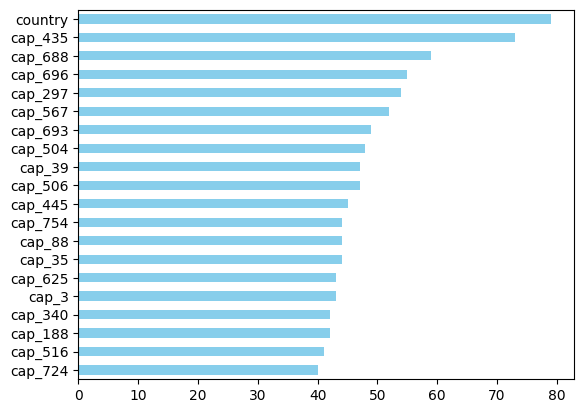

In [458]:
importance_df = pd.Series(index=features, data=cem.model.feature_importances_, name='feature importance')

top_features = importance_df.sort_values(ascending=False).head(20).sort_values()

# Plot the top features
top_features.plot.barh(color='skyblue')

In [461]:
cem = CreativeEffectivenessModel('nn2', features, target)
cem_error = cem.train_eval(train_data, test_data)

Epoch [1/40],Loss: 0.5254
Epoch [2/40],Loss: 0.4673
Epoch [3/40],Loss: 0.4121
Epoch [4/40],Loss: 0.3552
Epoch [5/40],Loss: 0.2907
Epoch [6/40],Loss: 0.2288
Epoch [7/40],Loss: 0.1880
Epoch [8/40],Loss: 0.1547
Epoch [9/40],Loss: 0.1248
Epoch [10/40],Loss: 0.1141
Epoch [11/40],Loss: 0.1103
Epoch [12/40],Loss: 0.1066
Epoch [13/40],Loss: 0.1298
Epoch [14/40],Loss: 0.0871
Epoch [15/40],Loss: 0.0737
Epoch [16/40],Loss: 0.0708
Epoch [17/40],Loss: 0.0646
Epoch [18/40],Loss: 0.0631
Epoch [19/40],Loss: 0.0627
Epoch [20/40],Loss: 0.0579
Epoch [21/40],Loss: 0.0552
Epoch [22/40],Loss: 0.0533
Epoch [23/40],Loss: 0.0535
Epoch [24/40],Loss: 0.0501
Epoch [25/40],Loss: 0.0496
Epoch [26/40],Loss: 0.0443
Epoch [27/40],Loss: 0.0471
Epoch [28/40],Loss: 0.0496
Epoch [29/40],Loss: 0.0638
Epoch [30/40],Loss: 0.0577
Epoch [31/40],Loss: 0.0526
Epoch [32/40],Loss: 0.0473
Epoch [33/40],Loss: 0.0490
Epoch [34/40],Loss: 0.0425
Epoch [35/40],Loss: 0.0399
Epoch [36/40],Loss: 0.0389
Epoch [37/40],Loss: 0.0503
Epoch [38/

In [475]:
features = [
   # 'no_of_days', 'no_of_week_end',
   # 'Display_days', 'Mobile_days', 'Search_days', 'Social_days',
   # 'Video_days',
   'country', 'aspect_ratio',
     'color', 'read_mean', 'green_mean', 'blue_mean',
   # 'red_std', 'green_std', 'blue_std',
    'brightness', 'contrast', 'entropy',
    'warm_fraction', 'cool_fraction', 'saturation_mean',
    #'red_dom_color0',
   # 'green_dom_color0', 'blue_dom_color0', 'weight_dom_color0',
   # 'red_dom_color1', 'green_dom_color1', 'blue_dom_color1',
   # 'weight_dom_color1', 'red_dom_color2', 'green_dom_color2',
   # 'blue_dom_color2', 'weight_dom_color2', 'red_dom_color3',
   # 'green_dom_color3', 'blue_dom_color3', 'weight_dom_color3',
   # 'red_dom_color4', 'green_dom_color4', 'blue_dom_color4',
   # 'weight_dom_color4', 'red_dom_color5', 'green_dom_color5',
   # 'blue_dom_color5', 'weight_dom_color5', 'red_dom_color6',
   # 'green_dom_color6', 'blue_dom_color6', 'weight_dom_color6',
   # 'red_dom_color7', 'green_dom_color7', 'blue_dom_color7',
   # 'weight_dom_color7', 'red_dom_color8', 'green_dom_color8',
   # 'blue_dom_color8', 'weight_dom_color8', 'red_dom_color9',
   # 'green_dom_color9', 'blue_dom_color9', 'weight_dom_color9'
    ]
#features += vit_features2_columns
features += cap_features_columns
target = 'effective'

In [476]:
cem = CreativeEffectivenessModel('lgbm', features, target)
cem_error = cem.train_eval(train_data, test_data)

Accuracy: 0.78
ROC AUC: 0.53
Precision: 0.19
Recall: 0.056
F1 Score: 0.086


<Axes: >

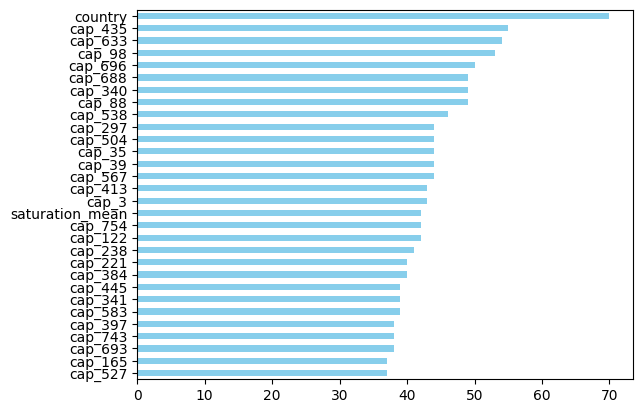

In [478]:
importance_df = pd.Series(index=features, data=cem.model.feature_importances_, name='feature importance')

top_features = importance_df.sort_values(ascending=False).head(30).sort_values()

# Plot the top features
top_features.plot.barh(color='skyblue')